In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
%matplotlib inline
import matplotlib.pyplot as plt
from rtree import index

#import models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
#from xgboost import XGBRegressor
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

from sklearn import model_selection
from sklearn.metrics import explained_variance_score
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from tabulate import _table_formats, tabulate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pygad
import time
import datetime

from sklearn import metrics

In [2]:
# datas = '../MyData.xlsx'
datas = '/Users/pkrok/OneDrive/Python/Giannakopoulos/MyData.xlsx'
# datas = '/Users/panagiotiskrokidas/OneDrive/Python/Giannakopoulos/MyData.xlsx'

In [3]:
pd.set_option("display.max_columns", None)
df=pd.read_excel(datas)
df.head(2)
df['logD'] = np.log10(df['diffusivity'])
# df = df.dropna()
# df[df.gas == 'propylene']['logD'].max()
df[df.gas == 'N2']['logD'].count()

71

# Keep only the columns I need

In [4]:
# df2=df[[ 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'gas', 'apertureAtom_e', 'ionicRad']]
df2=df[[ 'type', 'gas', 'MetalNum', 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'ionicRad', 
       'Μ-N_lff', 'Μ-N_kFF', 'MetalCharge', 'MetalMass',
       'apertureAtom_σ', 'apertureAtom_e', 'linker_length1', 'linker_length2',
       'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
       'func1_length', 'func2_length', 'func3_length', 'func1_mass',  
       'func2_mass', 'func3_mass', 'func1_charge', 'func2_charge',
       'func3_charge',]]

In [5]:
df2=df2.rename(columns={'size - van der Waals (Å)':'diameter', 'size - kinetic diameter (Å)':'kdiameter', 'apertureAtom_σ':'σ', 'apertureAtom_e':'e' })

In [6]:
df2 = df2.dropna()
df2=df2.reset_index(drop=True)

df2=df2[
# (df2['gas'] != 'isobutane') & (df2['gas'] != 'iso-butane')
(df2['gas'] != 'SF6')
#  (df2['gas'] != 'Rn')
].reset_index()

df2 = df2.dropna()
df2=df2.reset_index(drop=True)
# df2
# df2[(df2['logD'] >= -13) & (dfco2['logD'] <= -11.5)]

## Propylene/propane dataframes

In [7]:
df2[(df2['type'] == 'ZIF-67')]
# dfco2[(dfco2['logD'] >= -12)]

,index,type,gas,MetalNum,aperture,diameter,mass,ascentricF,logD,kdiameter,ionicRad,Μ-N_lff,Μ-N_kFF,MetalCharge,MetalMass,σ,e,linker_length1,linker_length2,linker_length3,linker_mass1,linker_mass2,linker_mass3,func1_length,func2_length,func3_length,func1_mass,func2_mass,func3_mass,func1_charge,func2_charge,func3_charge
43,45,ZIF-67,He,27,3.32,2.66,4.002,-0.390,-7.872895,2.60,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342
44,46,ZIF-67,H2,27,3.32,2.76,2.010,-0.217,-8.060481,2.89,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342
45,47,ZIF-67,O2,27,3.32,2.94,31.999,0.022,-9.010105,3.46,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342
46,48,ZIF-67,CO2,27,3.32,3.24,44.010,0.225,-9.352617,3.30,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342
47,49,ZIF-67,N2,27,3.32,3.13,28.000,0.037,-9.602060,3.64,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342
48,50,ZIF-67,CH4,27,3.32,3.25,16.040,0.011,-11.364516,3.80,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342
49,51,ZIF-67,ethylene,27,3.32,3.59,28.050,0.087,-10.698970,3.90,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342
50,52,ZIF-67,ethane,27,3.32,3.72,30.070,0.099,-11.397940,4.00,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342
51,53,ZIF-67,propylene,27,3.32,4.03,42.080,0.142,-12.522879,4.50,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342
52,54,ZIF-67,propane,27,3.32,4.16,44.100,0.152,-14.823909,4.30,72,2.044,58910.7,1.3497,58.93,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1342,-0.1342,-0.1342


In [8]:
a=df2[(df2['type'] == 'ZIF-67') & (df2['gas'] == 'propylene')]['logD']
b=df2[(df2['type'] == 'ZIF-67') & (df2['gas'] == 'propane')]['logD']
print(a)
print(b)

51   -12.522879
Name: logD, dtype: float64
52   -14.823909
Name: logD, dtype: float64


In [9]:
propylene = a.values[0]
propane = b.values[0]
Ratio = propylene - propane
print(Ratio)

2.3010299956639813


In [10]:
# dfc3h6 = dfc3h6.drop([dfc3h6.index[3]])
# dfc3h8 = dfc3h8.drop([dfc3h8.index[3]])
df2.drop(df2[df2['type'] == 'ZIF-67'].index, inplace = True)

In [11]:
df2

,index,type,gas,MetalNum,aperture,diameter,mass,ascentricF,logD,kdiameter,ionicRad,Μ-N_lff,Μ-N_kFF,MetalCharge,MetalMass,σ,e,linker_length1,linker_length2,linker_length3,linker_mass1,linker_mass2,linker_mass3,func1_length,func2_length,func3_length,func1_mass,func2_mass,func3_mass,func1_charge,func2_charge,func3_charge
0,0,CdIF-1,He,48,3.92,2.66,4.002,-0.390,-7.221849,2.60,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
1,1,CdIF-1,H2,48,3.92,2.76,2.010,-0.217,-7.301030,2.89,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
2,2,CdIF-1,O2,48,3.92,2.94,31.999,0.022,-8.000000,3.46,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
3,3,CdIF-1,CO2,48,3.92,3.24,44.010,0.225,-8.397940,3.30,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
4,4,CdIF-1,N2,48,3.92,3.13,28.000,0.037,-8.301030,3.64,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,945,dIm_Mg,propylene,12,2.95,4.03,42.080,0.142,-13.853872,4.50,71,2.139,38994.88,1.9871,24.305,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710
942,946,dIm_Mg,propane,12,2.95,4.16,44.100,0.152,-17.397940,4.30,71,2.139,38994.88,1.9871,24.305,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710
943,947,dIm_Mg,Kr,12,2.95,4.00,83.800,0.005,-11.308919,3.69,71,2.139,38994.88,1.9871,24.305,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710
944,948,dIm_Mg,Xe,12,2.95,4.10,131.290,0.008,-15.924453,4.10,71,2.139,38994.88,1.9871,24.305,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710


In [12]:
# dfc3h6=dfc3h6.reset_index()
# dfc3h6=dfc3h6.drop(columns=['index'])

# dfc3h8=dfc3h8.reset_index()
# dfc3h8=dfc3h8.drop(columns=['index'])

## ML models

In [13]:
df3 = df2[[
    # 'diameter',
     'MetalNum',  
     'linker_length1', 'linker_length2', 'linker_length3',
    'func1_length', 'func2_length', 'func3_length' 
                                 ]]

df4 = df3.drop_duplicates()
df4 = df4.reset_index(drop=True)
df4


,MetalNum,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length
0,48,4.438,4.438,4.438,3.78,3.78,3.780
1,30,4.438,4.438,4.438,3.78,3.78,3.780
2,29,4.438,4.438,4.438,3.78,3.78,3.780
3,4,4.438,4.438,4.438,3.78,3.78,3.780
4,30,4.438,4.438,5.996,3.78,3.78,2.278
...,...,...,...,...,...,...,...
66,4,6.410,6.410,6.410,3.78,3.78,3.780
67,27,6.410,6.410,6.410,3.78,3.78,3.780
68,29,6.410,6.410,6.410,3.78,3.78,3.780
69,48,6.410,6.410,6.410,3.78,3.78,3.780


# ga_instance.plot_genes()

## Add more descriptors

## Model with only metal, aperture_e, lengths of linker1&3 and functional1&3

In [14]:
Genes = np.asanyarray(df4[[
    # 'diameter',
     'MetalNum',  
     'linker_length1', 'linker_length2', 'linker_length3',
    'func1_length', 'func2_length', 'func3_length' 
                                 ]])

x_all = np.asanyarray(df2[[
    'diameter',
    'mass',
    'ascentricF',
    'kdiameter',
    'MetalNum',  
    'linker_length1', 'linker_length2', 'linker_length3',
    'func1_length', 'func2_length', 'func3_length',
    'ionicRad', 'MetalMass',
    'linker_mass1', 'linker_mass2', 'linker_mass3',
    'σ', 'e', 
    'func1_mass', 'func2_mass', 'func3_mass'
                            ]])


y_all = np.array(df2[['logD']])

# Libraries

In [15]:
linker_length1 = {3.66:{'linker_mass1':83, 'σ':0.325, 'e':0.7112},
                 4.438:{'linker_mass1':81, 'σ':0.25, 'e':0.0627},
                  4.86:{'linker_mass1':101.98, 'σ':0.285, 'e':0.255},
                   5.7:{'linker_mass1':134.906, 'σ':0.34, 'e':1.2552},
                  6.01:{'linker_mass1':223.8, 'σ':0.4, 'e':0.0627},
                  6.41:{'linker_mass1':317.8, 'σ':0.367, 'e':1.8731}
                  }

linker_length2 = {3.66:{'linker_mass2':83, 'σ':0.325, 'e':0.7112},
                 4.438:{'linker_mass2':81, 'σ':0.25, 'e':0.0627},
                  4.86:{'linker_mass2':101.98, 'σ':0.285, 'e':0.255},
                   5.7:{'linker_mass2':134.906, 'σ':0.34, 'e':1.2552},
                  6.01:{'linker_mass2':223.8, 'σ':0.4, 'e':0.0627},
                  6.41:{'linker_mass2':317.8, 'σ':0.367, 'e':1.8731}
                  }
linker_length3 = {3.66:{'linker_mass3':83, 'σ':0.325, 'e':0.7112},
                 4.438:{'linker_mass3':81, 'σ':0.25, 'e':0.0627},
                  4.86:{'linker_mass3':101.98, 'σ':0.285, 'e':0.255},
                   5.7:{'linker_mass3':134.906, 'σ':0.34, 'e':1.2552},
                 5.996:{'linker_mass3':117., 'σ':0.25, 'e':0.0627},
                  6.01:{'linker_mass3':223.8, 'σ':0.4, 'e':0.0627},
                  6.41:{'linker_mass3':317.8, 'σ':0.367, 'e':1.8731}
                  }

func1_length = {2.278:{'func1_mass':1.},
                 3.54:{'func1_mass':35.45},
                  3.78:{'func1_mass':15.},
                   3.85:{'func1_mass':79.9},
                  3.927:{'func1_mass':16.},
                  4.093:{'func1_mass':31.}
                  }

func2_length = {2.278:{'func2_mass':1.},
                 3.54:{'func2_mass':35.45},
                  3.78:{'func2_mass':15.},
                   3.85:{'func2_mass':79.9},
                  3.927:{'func2_mass':16.},
                  4.093:{'func2_mass':31.}
                  }

func3_length = {2.278:{'func3_mass':1.},
                    2.7:{'func3_mass':18.99},
                  3.54:{'func3_mass':35.45},
                  3.78:{'func3_mass':15.},
                   3.85:{'func3_mass':79.9},
                  3.927:{'func3_mass':16.},
                  4.093:{'func3_mass':31.},
                   4.25:{'func3_mass':127.},
                  }
MetalNum = {4:{'ionicRad':41, 'MetalMass': 9.012},
           29:{'ionicRad':71,'MetalMass': 63.456},
           12:{'ionicRad':71, 'MetalMass': 24.305},
           27:{'ionicRad':72, 'MetalMass': 58.930},
           30:{'ionicRad':74, 'MetalMass': 65.380},
           25:{'ionicRad':80, 'MetalMass': 54.938},
           48:{'ionicRad':92, 'MetalMass': 112.411}}

In [128]:
GBR = GradientBoostingRegressor(n_estimators=500, learning_rate=0.2, max_depth=4, random_state=0,loss='squared_error')

XGBR = XGBRegressor(n_estimators=600, max_depth=5, eta=0.2, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                    # n_jobs=6,
                    nthread=1,
                    random_state=610
                   )

model = XGBR.fit(x_all, y_all)

#ZIF-67
predictionc3h8=model.predict([[4.16, 44.1, 0.152, 4.3, 27, 4.438, 4.438, 4.438, 3.78, 3.78, 3.78, 72, 58.93, 81, 81, 81, 0.25, 0.0627, 15, 15, 15 ]])
predictionc3h6=model.predict([[4.03, 42.08, 0.142, 4.5, 27, 4.438, 4.438, 4.438, 3.78, 3.78, 3.78, 72, 58.93, 81, 81, 81, 0.25, 0.0627, 15, 15, 15 ]])


print(predictionc3h6)
print(predictionc3h8)

S= predictionc3h6 - predictionc3h8
print(S)

[-12.073981]
[-14.317998]
[2.2440166]


## Set up my GA

In [301]:
def fitness(solution, solution_idx):
    diameter_c3h6 = np.array([4.03])
    diameter_c3h8 = np.array([4.16])
    mass_c3h6 = np.array([42.08])
    mass_c3h8 = np.array([44.1])
    ascF_c3h6 = np.array([0.142])
    ascF_c3h8 = np.array([0.152])
    kD_c3h6 = np.array([4.5])
    kD_c3h8 = np.array([4.3])
    
    # targetD = -12.5
    # targetR = 2
    
    boundaries_D = np.array([-12.5, -11.5])
    boundaries_R = np.array([2.0, 2.5])
    
    solution2=np.array([
                  MetalNum[solution[0]]['ionicRad'],
                  MetalNum[solution[0]]['MetalMass'],
                  linker_length1[solution[1]]['linker_mass1'],
                  linker_length2[solution[2]]['linker_mass2'],
                  linker_length3[solution[3]]['linker_mass3'],
                  linker_length1[solution[1]]['σ'],
                  linker_length1[solution[1]]['e'],
                  func1_length[solution[4]]['func1_mass'],
                  func2_length[solution[5]]['func2_mass'],
                  func3_length[solution[6]]['func3_mass']])
    
    solution_c3h6=np.concatenate((diameter_c3h6, mass_c3h6, ascF_c3h6, kD_c3h6, solution,solution2), axis=0, out=None, dtype=None, casting="same_kind")
    solution_c3h8=np.concatenate((diameter_c3h8, mass_c3h8, ascF_c3h8, kD_c3h8,solution,solution2), axis=0, out=None, dtype=None, casting="same_kind")
    
    estimated_c3h6_diffusivity  = model.predict([solution_c3h6])[0]
    estimated_c3h8_diffusivity  = model.predict([solution_c3h8])[0]

    Ratio = estimated_c3h6_diffusivity - estimated_c3h8_diffusivity
    
    DiffusivityContribution = 1.0/(abs(np.min(boundaries_D) - estimated_c3h6_diffusivity) + abs(np.max(boundaries_D) - estimated_c3h6_diffusivity))
    RatiosContribution = 1.0/(abs(np.min(boundaries_R) - Ratio) + abs(np.max(boundaries_R) - Ratio))
    
    # DiffusivityContribution = 1.0/(np.log10(abs(np.min(boundaries_D) - estimated_c3h6_diffusivity)) + np.log10(abs(np.max(boundaries_D) - estimated_c3h6_diffusivity)))
    # RatiosContribution = 1.0/(np.log10(abs(np.min(boundaries_R) - Ratio)) + np.log10(abs(np.max(boundaries_R) - Ratio)))

    # DiffusivityContribution = 1/(np.power((abs(np.min(boundaries_D) - estimated_c3h6_diffusivity)),2) + np.power((abs(np.max(boundaries_D) - estimated_c3h6_diffusivity)),2))
    # RatiosContribution = 1/(np.power((abs(np.min(boundaries_R) - Ratio)),2) + np.power((abs(np.max(boundaries_R) - Ratio)),2))
    
    overallFitnessMeasure = 0.5*DiffusivityContribution + 0.5*RatiosContribution
    return overallFitnessMeasure

In [302]:
fitness_function = fitness

num_generations = 500 # 2000, 12000
num_parents_mating = 6 # 20,  22  #number of solutions to be selected as parents
 
mutation_probability = [0.5, 0.02] # originally [0.4, 0.01]
mutation_type = "adaptive" # random, swap, inversion, scramble, adaptive

# df5 = df4.sample(n=40)

Genes = np.asanyarray(df4[[
    # 'diameter',
     'MetalNum',  
     'linker_length1', 'linker_length2', 'linker_length3',
    'func1_length', 'func2_length', 'func3_length' 
                                 ]])

# initial_population = Genes[0:70]
initial_population = Genes

# narrowed down options
gene_space =  [
              [ 4,12,25,27,29,
              30,48
              ],
              [ 4.438, 4.86, 5.7, 6.01, 6.41],
              [ 4.438, 4.86, 5.7, 6.01, 6.41],
              [ 4.438, 4.86, 5.7,5.996,6.01, 6.41],
              [ 3.54, 3.78, 3.85,  4.093],
              [ 3.54, 3.78, 3.85,  4.093],
              # [ 3.54, 3.78, 3.85,  4.093]
              [2.278, 2.7, 3.54, 3.78, 3.85,  4.093, 4.25],
              ]

parent_selection_type = "tournament" #  "sss", "rws", "tournament", "rank", "random"
K_tournament = 8 #12
keep_parents = 2 # 4, 5
keep_elitism = 2

crossover_type = "uniform" # single_point, two_points, uniform, scattered
crossover_probability = 0.7

In [303]:
FiveBest = list()

In [304]:
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       initial_population = initial_population, 
                       parent_selection_type=parent_selection_type,
                       # keep_parents=keep_parents,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type, 
                       # mutation_num_genes = mutation_num_genes,
                       gene_space = gene_space,
                       # sol_per_pop = sol_per_pop,
                       # num_genes = num_genes,
                       crossover_probability = crossover_probability,
                       mutation_probability = mutation_probability,
                       K_tournament = K_tournament,
                       allow_duplicate_genes=False,
                       # stop_criteria = "reach_100",
                       # stop_criteria=["reach_127.4", "saturate_160"],
                    #    stop_criteria=["saturate_20"],
                       save_solutions=True,
                       random_seed=None,
                       suppress_warnings=True,
                       parallel_processing=["thread", 12],
                     #   parallel_processing=["process", 8],
                       # on_generation=on_generation,
                       save_best_solutions=True
                      )

# Single run

In [305]:
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-03-15 14:31:55


In [306]:
start_time = time.time()
ga_instance.run()
print("--- %s minutes ---" % ((time.time() - start_time)/60))

--- 3.333448008696238 minutes ---


In [307]:
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-03-15 14:35:15


In [308]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

diameter_c3h6 = np.array([4.03])
diameter_c3h8 = np.array([4.16])
mass_c3h6 = np.array([42.08])
mass_c3h8 = np.array([44.1])
ascF_c3h6 = np.array([0.142])
ascF_c3h8 = np.array([0.152])
kD_c3h6 = np.array([4.5])
kD_c3h8 = np.array([4.3])

solution2=np.array([
                  MetalNum[solution[0]]['ionicRad'],
                  MetalNum[solution[0]]['MetalMass'],
                  linker_length1[solution[1]]['linker_mass1'],
                  linker_length2[solution[2]]['linker_mass2'],
                  linker_length3[solution[3]]['linker_mass3'],
                  linker_length1[solution[1]]['σ'],
                  linker_length1[solution[1]]['e'],
                  func1_length[solution[4]]['func1_mass'],
                  func2_length[solution[5]]['func2_mass'],
                  func3_length[solution[6]]['func3_mass']])

solution_c3h6=np.concatenate((diameter_c3h6,mass_c3h6, ascF_c3h6, kD_c3h6, solution,solution2), axis=0, out=None, dtype=None, casting="same_kind")
solution_c3h8=np.concatenate((diameter_c3h8,mass_c3h8, ascF_c3h8, kD_c3h8,solution,solution2), axis=0, out=None, dtype=None, casting="same_kind")

predictionc3h6 = model.predict([solution_c3h6])[0]
predictionc3h8 = model.predict([solution_c3h8])[0]

print(predictionc3h6)
print(predictionc3h8)
S= predictionc3h6 - predictionc3h8
print(S)

Parameters of the best solution : [29.     4.86   6.41   4.438  3.85   4.093  3.78 ]
Fitness value of the best solution = 1.5
-11.679793
-14.015349
2.335556


In [309]:
solution
# ga_instance.best_solutions
# ga_instance.population

array([29.   ,  4.86 ,  6.41 ,  4.438,  3.85 ,  4.093,  3.78 ])

In [310]:
dfSol=pd.DataFrame(data = ga_instance.best_solutions)
dfSol.shape
# dfSol

(501, 7)

In [311]:
Sol=pd.DataFrame(data = ga_instance.best_solutions)
Sol2=Sol.drop_duplicates(keep='last')
Sol3 = Sol2.reset_index()
# Sol4 = Sol3.tail(20)
Sol3 = Sol3.drop(columns=['index'])
# Sol4 = Sol3.tail(20)
solutions = np.asanyarray(Sol3)
FiveBest.extend(solutions)

In [312]:
dfFiveBest=pd.DataFrame(data = FiveBest)
# dfFiveBest.loc[29]
# dfFiveBest.loc[41]
dfFiveBest=dfFiveBest.drop_duplicates(keep='last').reset_index(drop=True)
dfFiveBest

,0,1,2,3,4,5,6
0,12.0,4.86,4.86,4.860,3.78,3.780,3.78
1,29.0,5.70,6.41,4.438,3.85,3.540,3.78
2,29.0,6.01,6.41,4.438,3.85,4.093,3.78
3,29.0,5.70,6.41,4.438,3.85,4.093,3.78
4,29.0,5.70,6.01,4.438,3.85,3.540,3.78
5,29.0,4.86,6.01,4.438,3.85,3.540,3.78
6,29.0,5.70,6.01,4.438,3.85,4.093,3.78
7,29.0,4.86,6.01,4.438,3.85,4.093,3.78
8,29.0,4.86,6.41,4.438,3.85,3.540,3.78
9,29.0,4.86,5.70,4.438,3.85,3.540,3.78


In [313]:
# dfSol2=dfSol.drop_duplicates(keep='last')
# dfSol3 = dfSol2.reset_index()
# dfSol3 = dfSol3.drop(columns=['index'])
# dfSol3
# dfFiveBest = dfSol3
# dfFiveBest 

In [314]:
dfFiveBest[(dfFiveBest[0] == 27)
           & (dfFiveBest[1] == 4.438)
          ]

,0,1,2,3,4,5,6


In [315]:
dfFiveBest.loc[1]

0    29.000
1     5.700
2     6.410
3     4.438
4     3.850
5     3.540
6     3.780
Name: 1, dtype: float64

In [316]:
a=1

diameter_c3h6 = np.array([4.03])
diameter_c3h8 = np.array([4.16])
mass_c3h6 = np.array([42.08])
mass_c3h8 = np.array([44.1])
ascF_c3h6 = np.array([0.142])
ascF_c3h8 = np.array([0.152])
kD_c3h6 = np.array([4.5])
kD_c3h8 = np.array([4.3])

solution2=np.array([
                  MetalNum[dfFiveBest[0][a]]['ionicRad'],
                  MetalNum[solution[0]]['MetalMass'],
                  linker_length1[dfFiveBest[1][a]]['linker_mass1'],
                  linker_length2[dfFiveBest[2][a]]['linker_mass2'],
                  linker_length3[dfFiveBest[3][a]]['linker_mass3'],
                  linker_length1[dfFiveBest[1][a]]['σ'],
                  linker_length1[dfFiveBest[1][a]]['e'],
                  func1_length[dfFiveBest[4][a]]['func1_mass'],
                  func2_length[dfFiveBest[5][a]]['func2_mass'],
                  func3_length[dfFiveBest[6][a]]['func3_mass']])

solutionNew=np.array(dfFiveBest.loc[a])

solution3=np.concatenate((solutionNew,solution2), axis=0, out=None, dtype=None, casting="same_kind")

solution_c3h6=np.concatenate((diameter_c3h6,mass_c3h6, ascF_c3h6, kD_c3h6,solution,solution2), axis=0, out=None, dtype=None, casting="same_kind")
solution_c3h8=np.concatenate((diameter_c3h8,mass_c3h8, ascF_c3h8, kD_c3h8,solution,solution2), axis=0, out=None, dtype=None, casting="same_kind")

predictionc3h6 = model.predict([solution_c3h6])[0]
predictionc3h8 = model.predict([solution_c3h8])[0]

print(predictionc3h6)
print(predictionc3h8)
Ratio = predictionc3h6 - predictionc3h8
print(Ratio)

-11.679664
-14.048812
2.3691483


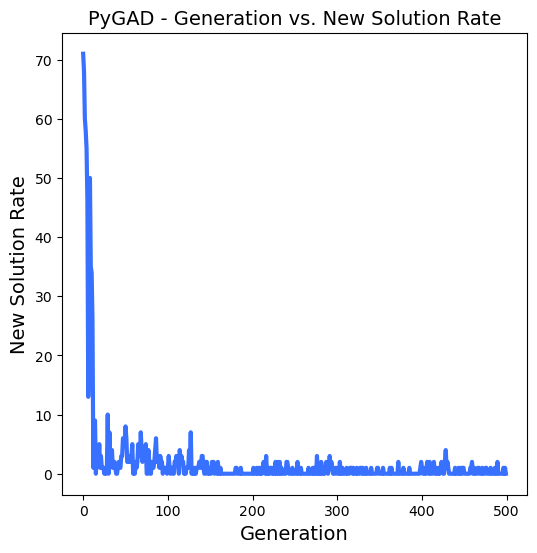

Figure(600x600)


In [317]:
print(ga_instance.plot_new_solution_rate())

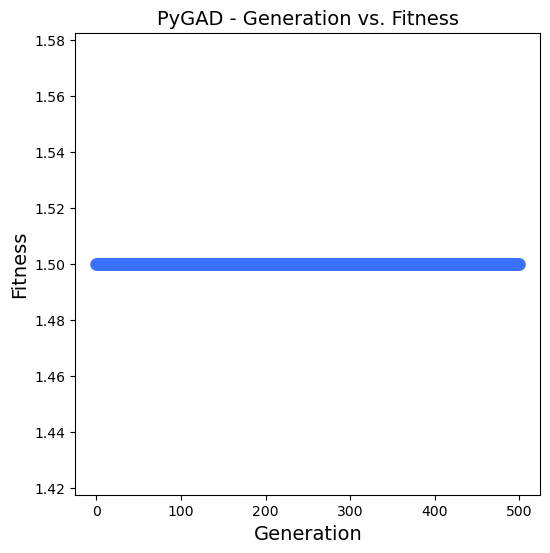

Figure(600x600)


In [318]:
print(ga_instance.plot_fitness(plot_type="scatter"))

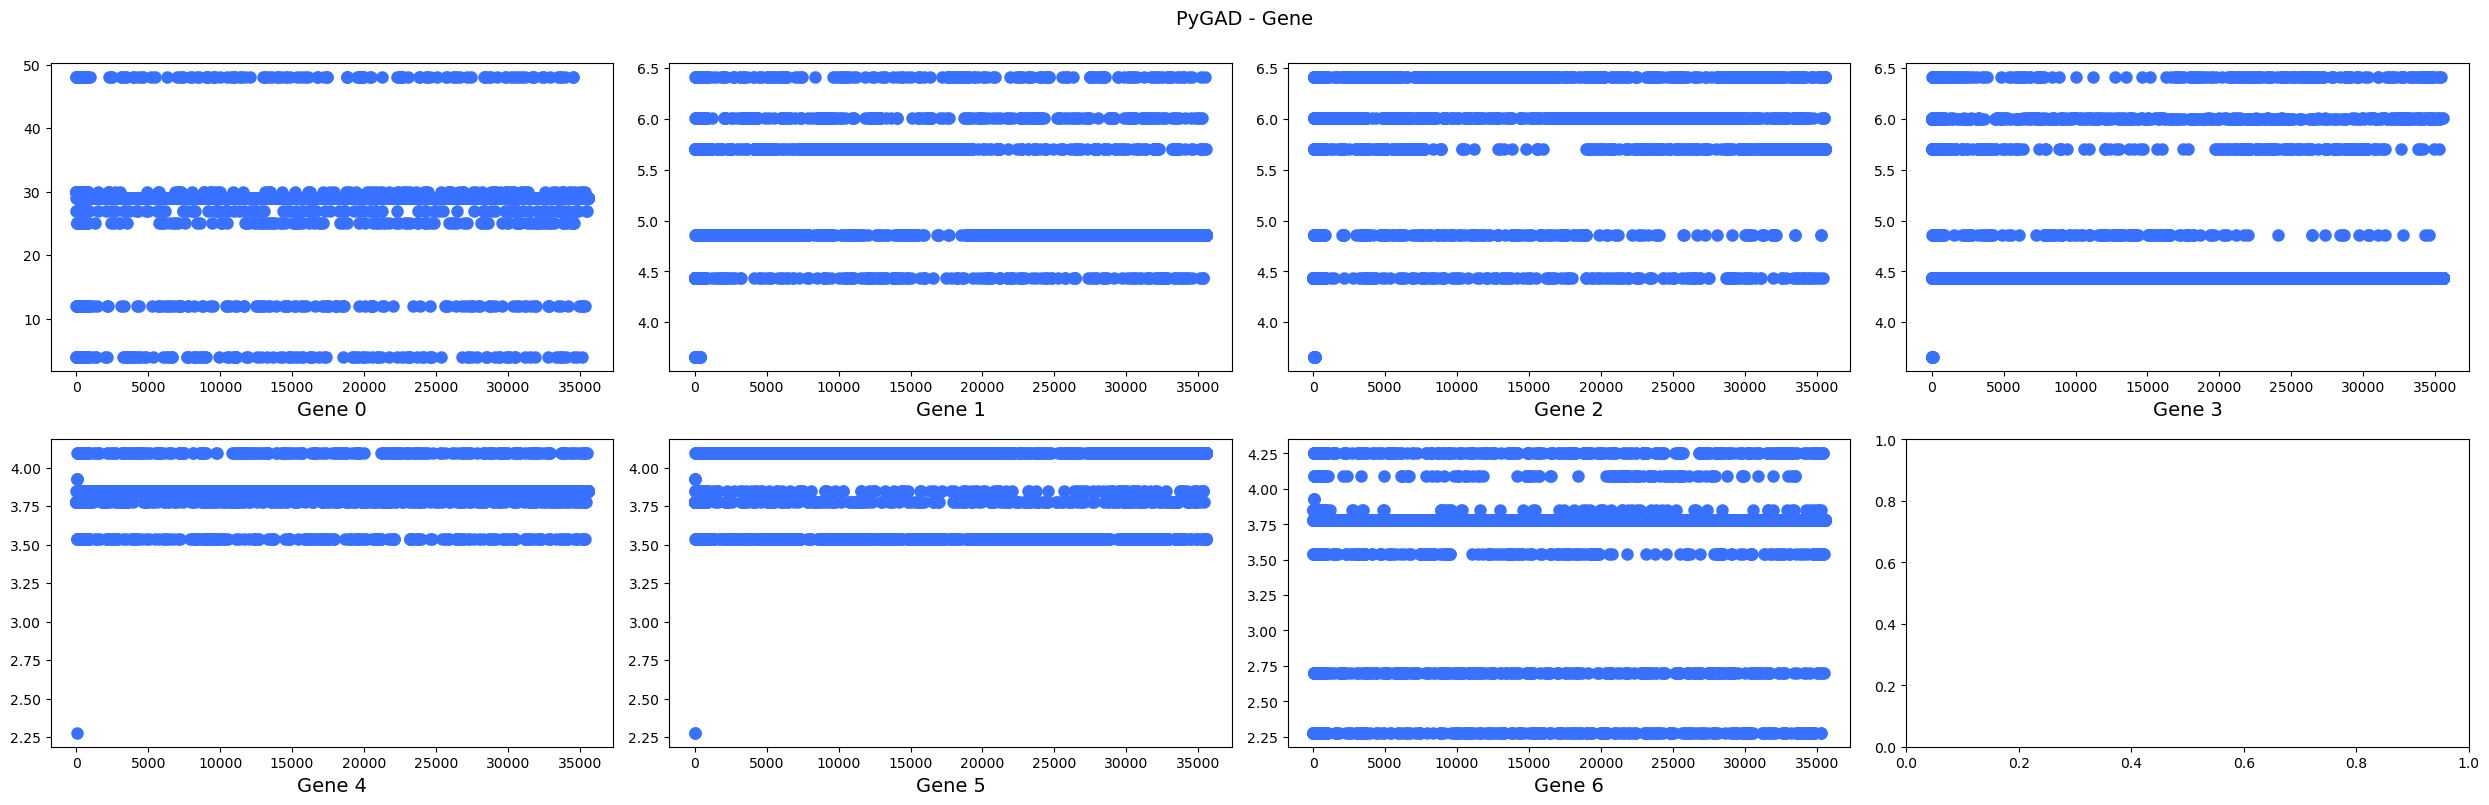

Figure(2500x800)


In [319]:
print(ga_instance.plot_genes(graph_type="plot",
                       plot_type="scatter",
                       solutions='all'))

In [320]:
ga_instance.previous_generation_fitness
# ga_instance.pop_size

array([1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 0.74443243, 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.27948164, 1.5       , 1.5       , 1.27767933, 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.17179159, 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.22987909, 1.5       ,
       1.5       ])

# Make a dataframe with all the best solutions in terms of logD and selectivity (ratio)

In [123]:
dfFiveBest=dfFiveBest.drop_duplicates(keep='last').reset_index(drop=True)
dfFiveBest

,0,1,2,3,4,5,6
0,12.0,4.86,4.860,4.86,3.78,3.780,3.780
1,27.0,5.70,6.410,4.86,3.85,3.780,4.093
2,27.0,5.70,4.438,4.86,3.78,3.850,2.278
3,27.0,5.70,6.410,4.86,3.78,3.540,2.278
4,27.0,5.70,6.010,4.86,3.78,4.093,2.278
5,27.0,5.70,6.010,4.86,3.78,3.850,2.278
6,27.0,5.70,6.410,4.86,3.78,4.093,2.278
7,27.0,5.70,6.410,4.86,3.78,3.850,2.278


In [233]:
from sqlalchemy import over

boundaries_D = np.array([-13, -12])
boundaries_R = np.array([2.1, 2.3])

BestZIFfromGA = pd.DataFrame(columns = [
        'number',
        'logD',
        'Ratio', 'fitness'])

diameter_c3h6 = np.array([4.03])
diameter_c3h8 = np.array([4.16])
mass_c3h6 = np.array([42.08])
mass_c3h8 = np.array([44.1])
ascF_c3h6 = np.array([0.142])
ascF_c3h8 = np.array([0.152])
kD_c3h6 = np.array([4.5])
kD_c3h8 = np.array([4.3])

for a in range(0,len(dfFiveBest)):
    solution2=np.array([
                  MetalNum[dfFiveBest[0][a]]['ionicRad'],
                  MetalNum[solution[0]]['MetalMass'],
                  linker_length1[dfFiveBest[1][a]]['linker_mass1'],
                  linker_length2[dfFiveBest[2][a]]['linker_mass2'],
                  linker_length3[dfFiveBest[3][a]]['linker_mass3'],
                  linker_length1[dfFiveBest[1][a]]['σ'],
                  linker_length1[dfFiveBest[1][a]]['e'],
                  func1_length[dfFiveBest[4][a]]['func1_mass'],
                  func2_length[dfFiveBest[5][a]]['func2_mass'],
                  func3_length[dfFiveBest[6][a]]['func3_mass']])

    solutionNew=np.array(dfFiveBest.loc[a])
    solution3=np.concatenate((solutionNew,solution2), axis=0, out=None, dtype=None, casting="same_kind")
    
    solution_c3h6=np.concatenate((diameter_c3h6,mass_c3h6, ascF_c3h6, kD_c3h6,solutionNew,solution2), axis=0, out=None, dtype=None, casting="same_kind")
    solution_c3h8=np.concatenate((diameter_c3h8,mass_c3h8, ascF_c3h8, kD_c3h8,solutionNew,solution2), axis=0, out=None, dtype=None, casting="same_kind")

    predictionc3h6 = model.predict([solution_c3h6])[0]
    predictionc3h8 = model.predict([solution_c3h8])[0]
    
    BestZIFfromGA.loc[a, ['number']] = a
    BestZIFfromGA.loc[a, ['logD']] = predictionc3h6
    BestZIFfromGA.loc[a, ['Ratio']] =predictionc3h6 -predictionc3h8 


    Ratio = predictionc3h6 - predictionc3h8
    
    DiffusivityContribution = 1.0/(abs(np.min(boundaries_D) - predictionc3h6) + abs(np.max(boundaries_D) - predictionc3h6))
    RatiosContribution = 1.0/(abs(np.min(boundaries_R) - Ratio) + abs(np.max(boundaries_R) - Ratio))
    
    overallFitnessMeasure = 0.5*DiffusivityContribution + 0.5*RatiosContribution

    BestZIFfromGA.loc[a, ['fitness']] = overallFitnessMeasure
    


print(predictionc3h6)
print(predictionc3h8)

-12.382656
-14.673169


# Plot the best solutions, along with the target value (logD vs Ratio)

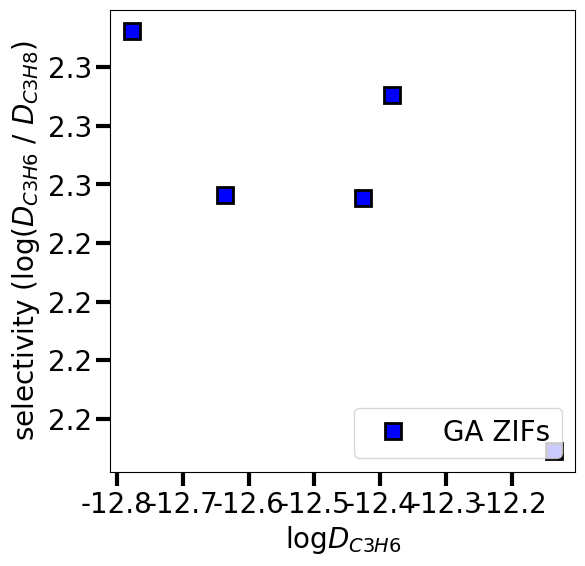

--- 0.0 seconds ---


In [234]:
plt.plot(BestZIFfromGA['logD'], BestZIFfromGA['Ratio'], 's', label='GA ZIFs', c='b', markersize='12', markeredgewidth=2, markeredgecolor='k')
# plt.plot(-11.5, 1.7, 'o', label='Target value', c='g', markersize='18', linewidth=4, markeredgecolor='k')

# plt.title ('$CO_{2}$/$CH_{4}$',fontsize=25)
plt.xlabel('log$D_{C3H6}$', fontsize=20)
plt.ylabel('selectivity (log($D_{C3H6}$ / $D_{C3H8}$)',fontsize=20)
plt.legend(loc='lower right', fontsize=20)


# plt.ylim(0.1, 3)
# plt.xlim(-14, -10)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
# plt.tick_params(which='major', length=4, color='m')
# plt.tick_params(which='minor', length=4, color='m')
plt.rcParams["figure.figsize"] = (6,6)
# plt.xscale('log')
# plt.yscale('log')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# plt.savefig('CO2_CH4_Maxwell.png', bbox_inches='tight', dpi=300, transparent=True)
plt.savefig('performance_c3h6_c3h8.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

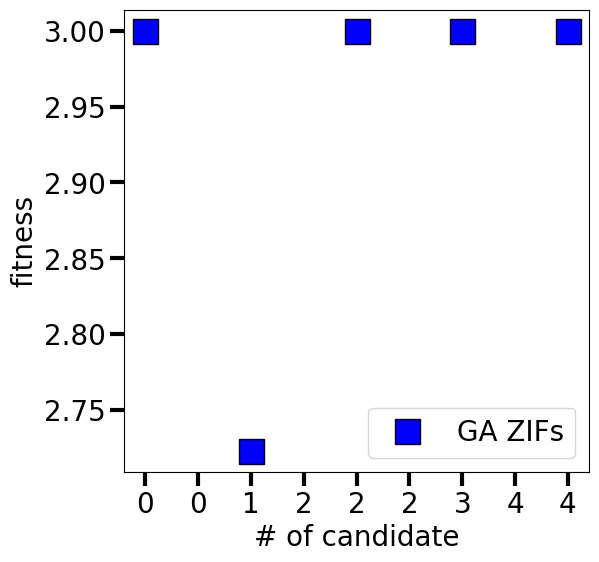

--- 0.0 seconds ---


In [235]:
plt.plot(BestZIFfromGA['number'], BestZIFfromGA['fitness'], 's', label='GA ZIFs', c='b', markersize='18', markeredgewidth=1, markeredgecolor='k')
# plt.plot(-11.5, 1.7, 'o', label='Target value', c='g', markersize='18', linewidth=4, markeredgecolor='k')

# plt.title ('$CO_{2}$/$CH_{4}$',fontsize=25)
plt.xlabel('# of candidate', fontsize=20)
plt.ylabel('fitness',fontsize=20)
plt.legend(loc='lower right', fontsize=20)


# plt.ylim(2, 4.5)
# plt.xlim(-10, -9)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
# plt.tick_params(which='major', length=4, color='m')
# plt.tick_params(which='minor', length=4, color='m')
plt.rcParams["figure.figsize"] = (6,6)
# plt.xscale('log')
# plt.yscale('log')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# plt.savefig('CO2_CH4_Maxwell.png', bbox_inches='tight', dpi=300, transparent=True)
plt.savefig('fitness_c3h6_c3h8.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

In [290]:
dfSol4 = dfSol3.tail(50)
# dfSol4 = dfSol4.drop(columns=['index'])
solutions = np.asanyarray(dfSol4)
FiveBest.extend(solutions)
FiveBest
dfFiveBest=pd.DataFrame(data = FiveBest)
dfFiveBest

,0,1,2,3,4,5,6
0,30.0,4.438,4.438,4.438,3.780,3.780,3.78
1,30.0,4.860,6.410,4.438,3.780,3.850,4.25
2,29.0,4.860,6.410,4.438,3.780,3.850,4.25
3,29.0,4.860,5.700,4.438,3.780,3.850,4.25
4,30.0,4.438,4.438,4.438,3.780,3.780,3.78
5,30.0,4.860,6.410,4.438,3.780,3.850,4.25
6,29.0,4.860,6.410,4.438,3.780,3.850,4.25
7,29.0,4.860,5.700,4.438,3.780,3.850,4.25
8,30.0,4.438,4.438,4.438,3.780,3.780,3.78
9,30.0,4.860,6.410,4.438,3.780,3.850,4.25
